## 必ず環境構築した上での実行をお願い致します
mmdetectionは本コード実行のために必要なフォルダであり私が自作したものではありません

In [1]:
%cd mmdetection
import warnings
warnings.simplefilter('ignore')

C:\Users\hikar\fixed_discrim\mmdetection


In [2]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import pycocotools.mask as mask
import mmcv
from mmcv.runner import load_checkpoint
from mmdet.core import encode_mask_results
from mmdet.apis import inference_detector
from mmdet.models import build_detector
import mmdet
import sys
import warnings
warnings.simplefilter('ignore')



class discrimination_fixed:
    '''
    撮影者が移動している状態で撮影された動画か移動していない状態で撮影された動画かを判別するクラス
    動画の最初のフレームと最後のフレームに対し、動被写体を覆い隠すマスクを適用し、背景部分の類似度を比較することで、判別を行う
    '''
    def __init__(self, video_file, thr=0.2, PSNR_thr = 11.5, SSIM_thr = 0.5):
        
        self.change_to_mmedit()
    
        self.video_file = "../" + video_file
        
        self.thr = thr
        self.PSNR_thr = PSNR_thr
        self.SSIM_thr = SSIM_thr
        
        self.model = self.set_model()
        
        self.capture_first_last_frame() #define  self.first_frame and self.last_frame         
        self.first_frame_im = cv2.imread(self.first_frame)
        self.last_frame_im = cv2.imread(self.last_frame)
        
        self.bbox_1, self.segm_1 = inference_detector(self.model, self.first_frame)
        self.bbox_2, self.segm_2 = inference_detector(self.model, self.last_frame)        
        self.bbox_1, self.segm_1, self.bbox_2, self.segm_2 = self.select_bbox_segm()

        
        self.mask_1,mask_list_1 = self.mask_output(self.segm_1, self.bbox_1, self.first_frame_im)
        self.mask_2,mask_list_2 = self.mask_output(self.segm_2, self.bbox_2, self.last_frame_im)
        
        self.synthesize_2mask() #define self.syn_mask
        
        self.double_masking_img()
        #define self.masking_first_frame_12 and self.masking_last_frame_12
        
        self.psnr_each = 0
        self.ssim = 0
        self.window_num = 0
        
        self.judge = "unknown" #fixed or unfixed


        
    def __call__(self, plt_bool=False):     

        if plt_bool==True:
            self.output_2img(self.masking_first_frame_12, self.masking_last_frame_12)
        
        self.psnr_each = self.portion_calculate_PSNR(self.masking_first_frame_12, self.masking_last_frame_12)
        self.ssim, self.window_num = self.SSIM_com(self.first_frame_im, self.last_frame_im, self.syn_mask)
        self.classify_file_with_PSNR_SSIM(self.psnr_each, self.ssim) #classify video

        return self.judge
    
    
    
    
    def change_to_mmedit(self):
        if not "mmdetection" == os.path.basename(os.getcwd()):    
                print('カレントディレクトリをmmdetectionにしてください')
                sys.exit()
                
    
    
    def set_model(self):
        config = 'configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
        checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
        device='cuda:0'
        
        config = mmcv.Config.fromfile(config)
        config.model.pretrained = None
        model = build_detector(config.model)
        checkpoint = load_checkpoint(model, checkpoint, map_location=device)
        model.CLASSES = checkpoint['meta']['CLASSES']
        model.cfg = config
        model.to(device)
        model.eval()
        
        return model
    
    
    
    def capture_first_last_frame(self):
        vidcap = cv2.VideoCapture(self.video_file)
        totalframecount = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
        frameIndex = totalframecount-1
        count = 0

        self.file_name  = os.path.basename(os.path.splitext(self.video_file)[0])

        if not os.path.isdir("../frame_%s" %(self.file_name)):
            os.makedirs("../frame_%s" %(self.file_name))

        if not os.path.isfile("../frame_%s/%s.png" % (self.file_name,str(count).zfill(6))):
            ret, image = vidcap.read()

            cv2.imwrite("../frame_%s/%s.png" % (self.file_name,str(count).zfill(6)), image)
            # save frame as png file
            success,image = vidcap.read()
            
        self.first_frame = "../frame_%s/%s.png" % (self.file_name,str(count).zfill(6))
        count += 1

        if not os.path.isfile("../frame_%s/%s.png" % (self.file_name,str(count).zfill(6))):
            vidcap.set(cv2.CAP_PROP_POS_FRAMES, frameIndex)
            ret, image = vidcap.read()

            if ret == False:
                while True:
                    frameIndex -= 1
                    vidcap.set(cv2.CAP_PROP_POS_FRAMES, frameIndex)
                    ret, image = vidcap.read()
                    if ret == True:
                        break

            cv2.imwrite("../frame_%s/%s.png" % (self.file_name,str(count).zfill(6)), image)
            # save frame as png file
            success,image = vidcap.read()
            
        self.last_frame = "../frame_%s/%s.png" % (self.file_name,str(count).zfill(6))
        return
    
        
    
    def select_bbox_segm(self):
        new_bbox_1 = []
        new_segm_1 = []
        new_bbox_2 = []
        new_segm_2 = []
        index_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
                      29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 
                      49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 63, 64, 65, 66, 67, 73, 75, 76, 77, 78, 79]
        for i in index_list:
            new_bbox_1.append(self.bbox_1[i])
            new_segm_1.append(self.segm_1[i])
            new_bbox_2.append(self.bbox_2[i])
            new_segm_2.append(self.segm_2[i])
        return new_bbox_1,new_segm_1,new_bbox_2,new_segm_2    

    
    
    def mask_output(self, seg, bbox, original_im):
        
        masking_img = np.ones_like(original_im)
        masking_img = masking_img[:,:,0]
        masking_img = masking_img[:,:,np.newaxis]
        seg_con = mmcv.concat_list(seg)

        if seg_con == []:#maskが一つもないなら全要素が１のマスクを出力
            return masking_img,seg_con

        enc_seg = encode_mask_results([seg_con])#encode
        mask_list=mask.decode(enc_seg[0])#decode 01
        bboxes = np.vstack(bbox)
        box_confidence = bboxes[:,-1]
        bool_ = len(box_confidence) == len(seg_con)

        count = 0
        for i in range(len(seg_con)):
            if box_confidence[i] > self.thr:
                maskedArr = mask_list[:,:,i]
                img = maskedArr
                img = img[:,:,np.newaxis]
                img = -img + 1 #reverse 01
                if count == 0:
                    masking_img = img
                    # concat_img = np.concatenate([img,img,img],axis=2)
                    # print(concat_img.shape)
                masking_img = np.multiply(masking_img,img)#broadcast automatically
                count += 1
        #mask_number = count
        return masking_img,mask_list
    
    
    
    #function to apply two mask
    def double_masking_img(self):
        self.masking_first_frame_12  = np.multiply(np.multiply(self.first_frame_im, self.mask_1), self.mask_2)
        self.masking_last_frame_12 = np.multiply(np.multiply(self.last_frame_im, self.mask_1), self.mask_2)
        return

    
    
    
    #function to output two images side by side
    def output_2img(self, img_1, img_2):

        img_1 = img_1.astype(np.uint8)
        img_2 = img_2.astype(np.uint8)

        mask_image_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
        mask_image_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
        fig = plt.figure(figsize = (12,4))
        ax = fig.add_subplot(1,2,1)
        ax.imshow(mask_image_1)
        ax.axis("off")
        ax.set_title("masked first frame")
        ax = fig.add_subplot(1,2,2)
        ax.imshow(mask_image_2)
        ax.axis("off")
        ax.set_title("masked last frame")
        
        if not os.path.isfile("../frame_%s/%s.png" % (self.file_name,"masked_first_frame")):
            cv2.imwrite("../frame_%s/%s.png" % (self.file_name,"masked_first_frame"),img_1)
        if not os.path.isfile("../frame_%s/%s.png" % (self.file_name,"masked_second_frame")):
            cv2.imwrite("../frame_%s/%s.png" % (self.file_name,"masked_second_frame"),img_2)


        
               
        
    def synthesize_2mask(self):
        self.syn_mask = np.multiply(self.mask_2, self.mask_1)
        return
    
    
    
    
    #function to calculate PSNR for some regions of the image
    def portion_calculate_PSNR(self, img1,img2):
        rss = np.sum((img1.astype(float) - img2.astype(float)) ** 2)
        divisor = np.count_nonzero(img1!=0)
        if rss == 0:
            return 100
        mse = rss/divisor
        PIXEL_MAX = 255.0
        PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

        return PSNR
    
    
    
    
    #function to calculate normal PSNR
    def psnr_a(self, img_1, img_2, data_range=255):
        mse = np.mean((img_1.astype(float) - img_2.astype(float)) ** 2)
        print(mse)
        return 10 * np.log10((data_range ** 2) / mse) 
    
    
    
    
    
    def calc_SSIM(self, image_0,image_1,mask_01):
        image_0 = image_0.astype(float)
        image_1 = image_1.astype(float)
        tile_size = 11
        pixel_len = 0
        width = image_0.shape[0]
        height = image_0.shape[1]
        width = width // tile_size * tile_size
        height = height // tile_size * tile_size
        dynamic_range = 255
        c_1 = (dynamic_range * 0.01) ** 2
        c_2 = (dynamic_range * 0.03) ** 2
        channels = range(image_0.shape[2])
        ssim = 0.0
        MSSIM = 0.0
        win_count = 0

        for x in range(0, width, tile_size):
            for y in range(0, height, tile_size):

                # Get pixel tile
                #box = (x, y, x + tile_size, y + tile_size)
                tile_0 = image_0[x:x+tile_size,y:y+tile_size,:]#image_0からタイルを取り出す(1)
                tile_1 = image_1[x:x+tile_size,y:y+tile_size,:]#image_1からタイルを取り出す(2)
                tile_mask_01 = mask_01[x:x+tile_size,y:y+tile_size,0]#mask01からタイルを取り出す(3)
                pixel_len = np.count_nonzero(tile_mask_01 != 0)#maskのタイルから0以外の要素をカウント(4)


                if pixel_len != 0:

                    for i in channels:
                        pixel0, pixel1 = tile_0[:,:,i], tile_1[:,:,i]#imageのタイルは3チャネルあるので、そのうち1つを取り出す(5)

                        covariance = 0.0

                        pixel_sum_0 = np.sum(pixel0[tile_mask_01 != 0])#tile_0から取り出したチャネルのうち0以外の要素を合計する(8)(o)
                        pixel_sum_1 = np.sum(pixel1[tile_mask_01 != 0])#tile_1から取り出したチャネルのうち0以外の要素を合計する(9)(o)

                        average_0 = pixel_sum_0 / pixel_len#(o)
                        average_1 = pixel_sum_1 / pixel_len#(o)

                        covariance = np.sum((pixel0[tile_mask_01 != 0] - average_0)*(pixel1[tile_mask_01 != 0] - average_1)) / pixel_len#(o)
                        # = np.cov(pixel0.reshape(-1), pixel1.reshape(-1))

                        # Calculate the sum of both image's variances
                        variance_0 = np.var(pixel0[tile_mask_01 != 0])#(o)
                        variance_1 = np.var(pixel1[tile_mask_01 != 0])
                        variance_0_1 = variance_0+variance_1

                        ssim = (2.0 * average_0 * average_1 + c_1) * (2.0 * covariance + c_2) / (average_0 * average_0 + average_1 * average_1 + c_1) / (variance_0_1 + c_2)
                        MSSIM += ssim

                        win_count += 1
                else:
                    MSSIM += 0.0

        MSSIM = MSSIM / win_count
        return MSSIM,win_count

    
    
    
    def SSIM_com(self, image_0, image_1, mask_01 = np.ones((240,320,1))):
        # Verify input parameters
        if image_0.shape != image_1.shape:
            raise AttributeError('The images do not have the same resolution')

        return self.calc_SSIM(image_0,image_1,mask_01)
      
    
    
    def classify_file_with_PSNR_SSIM(self, judge_PSNR, judge_SSIM):
        if (judge_PSNR > self.PSNR_thr) and (judge_SSIM > self.SSIM_thr):
            self.judge = "撮影者が動いていない状態で撮影された動画だ" #fixed         
        else:
            self.judge = "撮影者が動いている状態で撮影された動画だ" #unfixed
        return

In [3]:
tennis = discrimination_fixed("v_TennisSwing_g15_c01.avi")

load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


'撮影者が動いていない状態で撮影された動画だ'

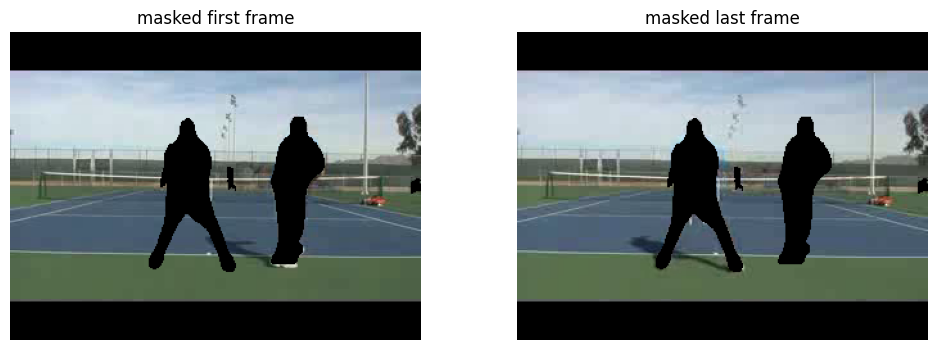

In [4]:
tennis(plt_bool = True)

In [5]:
hammer = discrimination_fixed("v_HammerThrow_g11_c02.avi")

load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


'撮影者が動いている状態で撮影された動画だ'

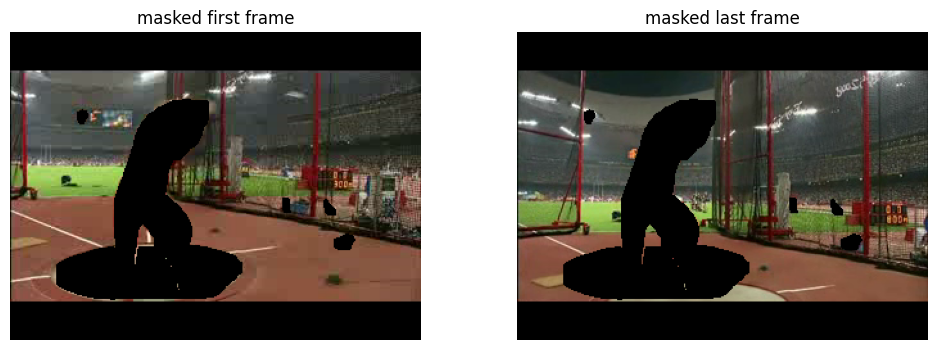

In [6]:
hammer(plt_bool=True)